In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist
import seaborn as sns

# 1. Dataset Preparation

## 1.1 Loading Dataset

In [2]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 71)


,date,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,males_ratio,killed_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,771.0,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1491.0,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,1.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1131.0,42.4190,-83.0393,38.0,38.0,39.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1132.0,38.9030,-76.9820,17.0,17.0,17.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,770.0,40.4621,-80.0308,22.0,25.0,26.0,0.0,1.0,1.0,0.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


In [3]:
print("There are NaN values:", dataset.isnull().values.any())

There are NaN values: False


In [4]:
print(dataset.columns)

Index(['date', 'latitude', 'longitude', 'min_age_participants',
       'avg_age_participants', 'max_age_participants', 'teen_ratio',
       'adults_ratio', 'males_ratio', 'killed_ratio', 'injured_ratio',
       'arrested_ratio', 'n_participants', 'povertyPercentage', 'party',
       'votes_ratio', 'totalvotes', 'population', 'state_Alabama',
       'state_Alaska', 'state_Arizona', 'state_Arkansas', 'state_California',
       'state_Colorado', 'state_Connecticut', 'state_Delaware',
       'state_District of Columbia', 'state_Florida', 'state_Georgia',
       'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana',
       'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Louisiana',
       'state_Maine', 'state_Maryland', 'state_Massachusetts',
       'state_Michigan', 'state_Minnesota', 'state_Mississippi',
       'state_Missouri', 'state_Montana', 'state_Nebraska', 'state_Nevada',
       'state_New Hampshire', 'state_New Jersey', 'state_New Mexico',
       'state_New York

In [5]:
dropped_columns = [c for c in dataset.columns if c.startswith('state_')]
dropped_columns += ['min_age_participants', 'max_age_participants', 'teen_ratio', 'totalvotes']
print("Attributes to drop:", dropped_columns)
dataset_reduced = dataset.drop(columns=dropped_columns, axis = 1)
print("Shape of dataset:", dataset_reduced.shape)

Attributes to drop: ['state_Alabama', 'state_Alaska', 'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado', 'state_Connecticut', 'state_Delaware', 'state_District of Columbia', 'state_Florida', 'state_Georgia', 'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland', 'state_Massachusetts', 'state_Michigan', 'state_Minnesota', 'state_Mississippi', 'state_Missouri', 'state_Montana', 'state_Nebraska', 'state_Nevada', 'state_New Hampshire', 'state_New Jersey', 'state_New Mexico', 'state_New York', 'state_North Carolina', 'state_North Dakota', 'state_Ohio', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania', 'state_Rhode Island', 'state_South Carolina', 'state_South Dakota', 'state_Tennessee', 'state_Texas', 'state_Utah', 'state_Vermont', 'state_Virginia', 'state_Washington', 'state_West Virginia', 'state_Wisconsin', 'state_Wyoming', 'min_age_participants', 'ma

In [6]:
numeric_dataset = dataset_reduced._get_numeric_data()
print("Shape of numeric_dataset:", numeric_dataset.shape)
numeric_dataset.head()

Shape of numeric_dataset: (239381, 16)


,date,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,votes_ratio,population,month_x,month_y
0,771.0,39.8322,-86.2492,19.0,1.0,1.0,0.0,1.0,0.0,1,12.3,0,0.547323,6611442,5.000000e-01,-0.866025
1,1491.0,41.6645,-78.7856,62.0,1.0,1.0,1.0,0.0,0.0,1,10.5,1,0.671644,12794679,8.660254e-01,-0.500000
2,1131.0,42.4190,-83.0393,38.0,1.0,1.0,0.0,0.5,0.0,2,11.0,0,0.785066,9954117,-5.000000e-01,0.866025
3,1132.0,38.9030,-76.9820,17.0,1.0,1.0,0.0,1.0,0.0,2,14.9,1,1.000000,687576,-8.660254e-01,0.500000
4,770.0,40.4621,-80.0308,25.0,1.0,1.0,0.0,0.5,0.0,2,11.5,0,1.000000,12789838,1.224647e-16,-1.000000


## 1.2 Outlier detection

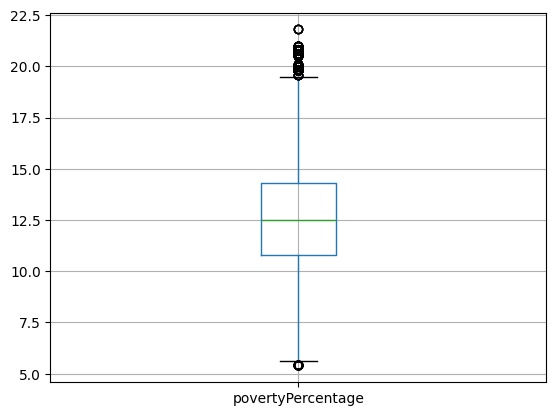

In [7]:
boxplot = dataset_reduced.boxplot(column=['povertyPercentage'])
plt.show()

Values for poverty percentages that are outliers are still realistic.

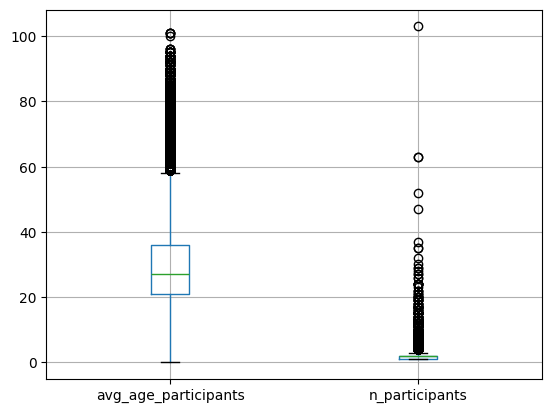

In [8]:
boxplot = dataset_reduced.boxplot(column = ['avg_age_participants', 'n_participants'])
plt.show()

Drop outliers for unrealistic values of avg age participants which may negatively influence clustering.

In [83]:
# Get whisker value of boxplot for avg_age_participants
boxplot = dataset_reduced.boxplot(column = ['avg_age_participants'], return_type='dict')
whiskers = boxplot['whiskers']
upper_whisker = whiskers[1].get_ydata()[1]
print("Upper whisker:", upper_whisker)

# Drop rows with avg_age_participants > upper_whisker
dataset_reduced = dataset_reduced[dataset_reduced['avg_age_participants'] <= upper_whisker]
print("Shape of dataset:", dataset_reduced.shape)

Upper whisker: 58.0
Shape of dataset: (230862, 16)


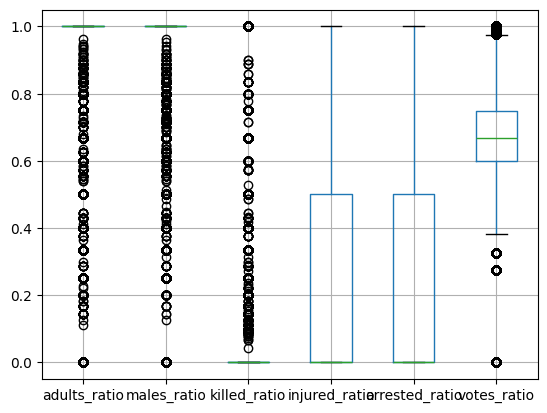

In [9]:
boxplot = dataset_reduced.boxplot(column = ['adults_ratio', 'males_ratio', 'killed_ratio', 'injured_ratio', 'arrested_ratio', 'votes_ratio'])
plt.show()

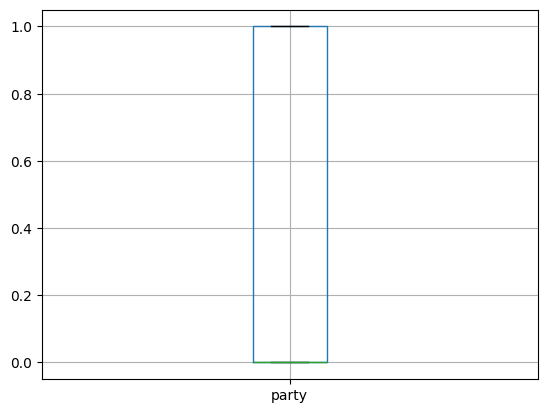

In [10]:
boxplot = dataset_reduced.boxplot(column = ['party'])
plt.show()

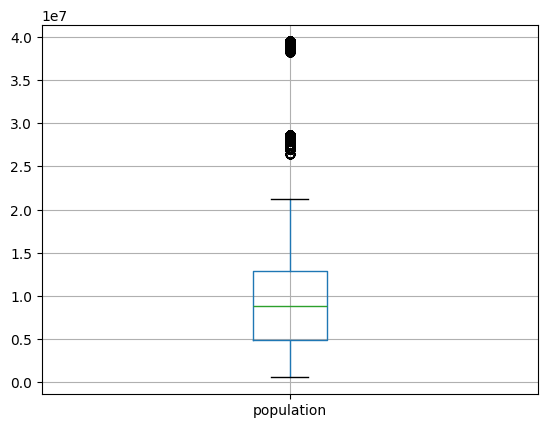

In [11]:
boxplot = dataset_reduced.boxplot(column = [ 'population'])

#### FUTURE : LOOK AT CITY DIMENSION HERE ####

plt.show()

## 1.3 Scaling

In [12]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(numeric_dataset.values)
scaled_dataset.shape

(239381, 16)

# 2. K Means

## 2.1 Identification of the best value of k

In [13]:
sse_list = []
silhouette_list = []
davies_bouldin_list = []

max_k = 20
for k in tqdm(range(2, max_k + 1), ):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_dataset)

    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(scaled_dataset, kmeans.labels_, sample_size=10000))
    davies_bouldin_list.append(davies_bouldin_score(scaled_dataset, kmeans.labels_))

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:55<00:00,  2.91s/it]


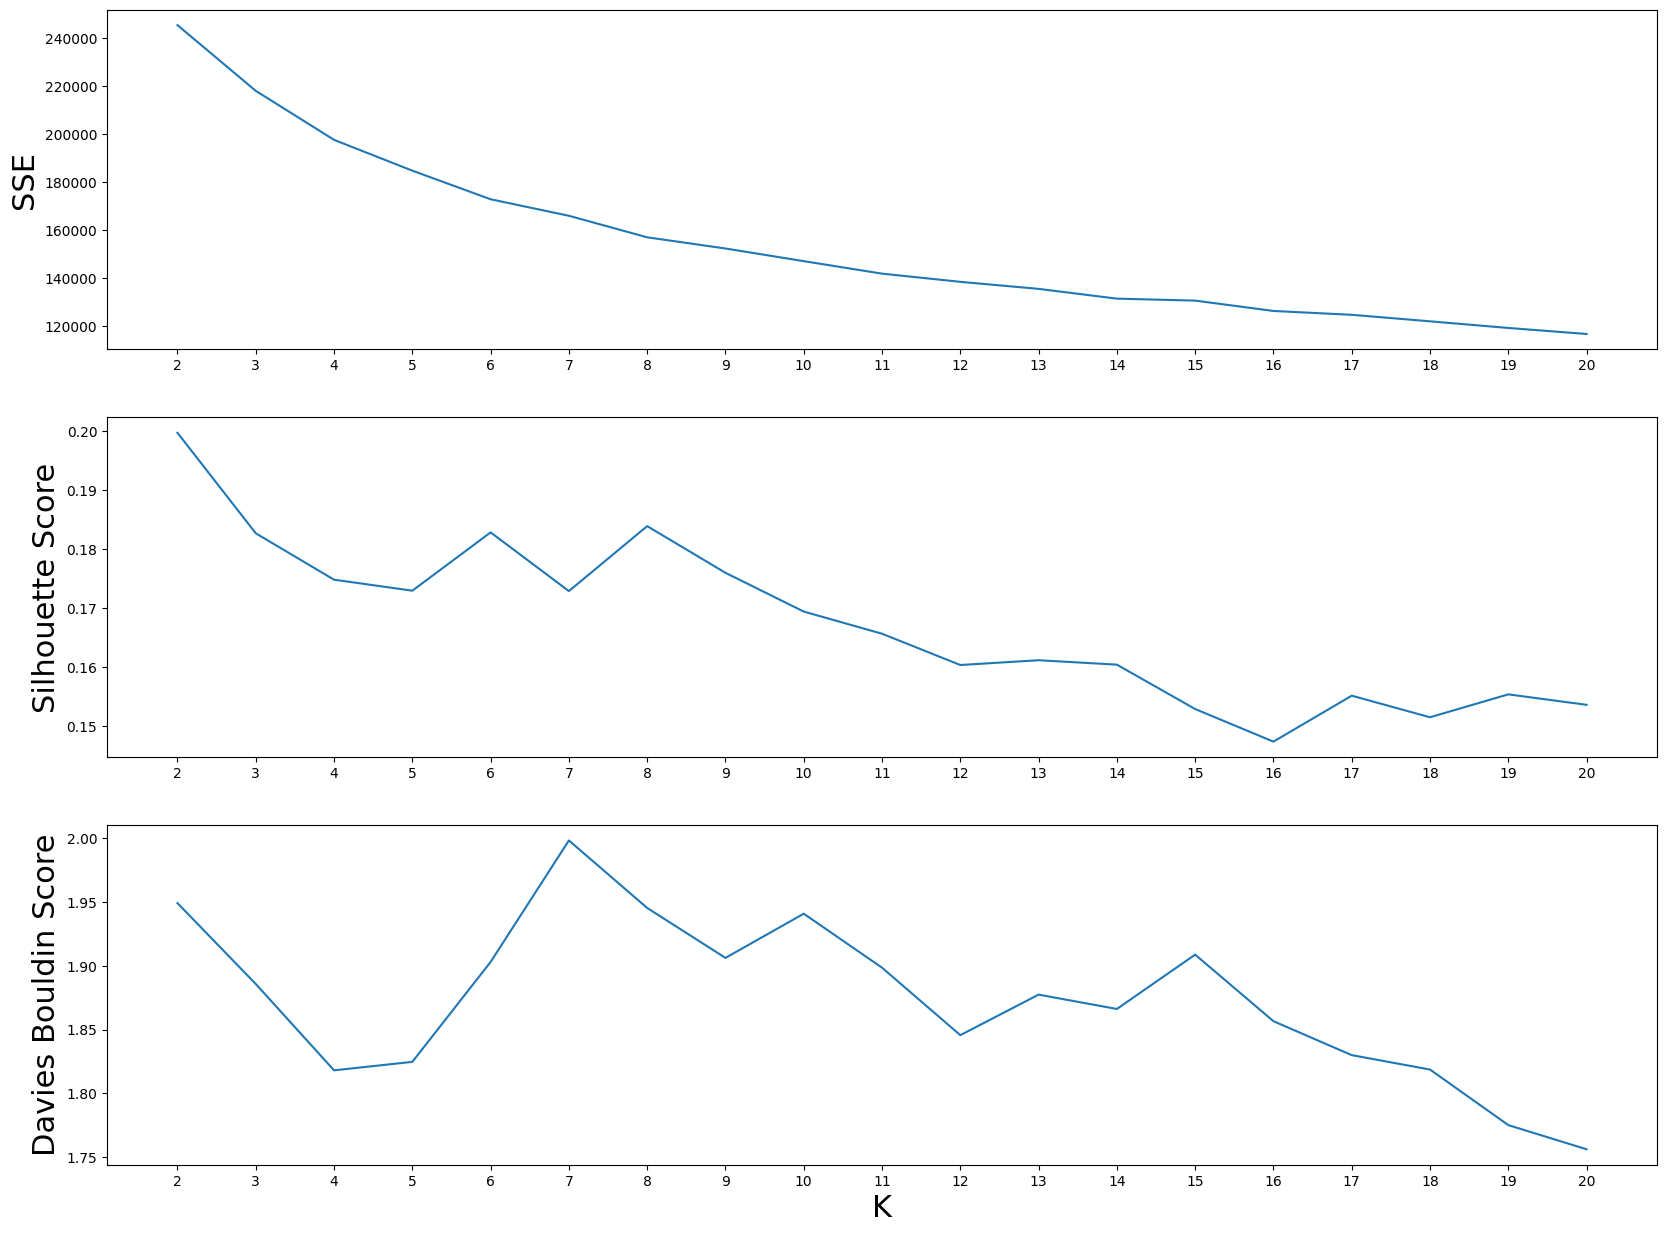

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhouette_list) + 2), silhouette_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list) + 2))

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)
ax[2].set_xticks(range(2, len(davies_bouldin_list) + 2))


plt.xlabel('K', fontsize=22)
plt.show()

# NICER PLOTS

## 2.2 Analysis of the centroids and clusters

In [28]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(scaled_dataset)

KMeans(n_clusters=6, n_init=10)

In [29]:
print("Shape of scaled_dataset: ", scaled_dataset.shape)
print("Shape of kmeans.labels_: ", kmeans.labels_.shape)
print("Shape of kmeans.cluster_centers_: ", kmeans.cluster_centers_.shape)

Shape of scaled_dataset:  (239381, 16)
Shape of kmeans.labels_:  (239381,)
Shape of kmeans.cluster_centers_:  (6, 16)


In [30]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=numeric_dataset.columns)
centers_df.head(7)

,date,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,party,votes_ratio,population,month_x,month_y
0,1162.220073,37.049620,-90.297442,30.982798,0.915127,0.887539,0.085713,0.011071,0.860924,1.802945,12.933400,1.000000e+00,0.652274,1.071635e+07,0.048686,0.039954
1,1031.431173,36.947772,-91.472506,33.307653,0.944514,0.886055,0.990716,0.002019,0.004682,1.252320,12.790094,3.772764e-01,0.691319,1.351808e+07,0.010773,0.017205
2,1195.216680,38.975496,-89.237555,29.343108,0.908818,0.906709,0.073242,0.039178,0.859029,1.846441,11.563720,2.281508e-14,0.674257,1.219179e+07,0.094282,0.051887
3,1034.482820,38.447432,-87.333593,27.839884,0.881394,0.879945,0.006012,0.973671,0.005605,1.445179,12.112851,2.486900e-14,0.721989,1.241421e+07,-0.026291,-0.051381
4,941.410504,36.428163,-89.138575,30.372727,0.913385,0.868530,0.041465,0.394791,0.054605,1.969360,13.596008,1.000000e+00,0.655880,1.028198e+07,-0.009353,-0.011816
5,925.263101,37.954730,-89.420937,29.804487,0.926885,0.888426,0.080863,0.169005,0.047607,2.240724,12.631217,2.758904e-14,0.703131,1.271077e+07,-0.025304,-0.037228


In [31]:
cluster_num_points = []
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[kmeans.labels_ == i])
    cluster_num_points.append(len(cluster_points[-1]))
    
cluster_num_points, cluster_points[0].shape

([32671, 25753, 32449, 38402, 59824, 50282], (32671, 16))

In [32]:
kmeans_tot = KMeans(n_clusters=1, n_init=10)
kmeans_tot.fit(scaled_dataset)
total_SSE = kmeans_tot.inertia_ / len(scaled_dataset)

cluster_SSE = []
for i in range(n_clusters):
    cluster_sse = 0
    for point in cluster_points[i]:
        cluster_sse += np.linalg.norm(point - kmeans.cluster_centers_[i])**2
    cluster_SSE.append(cluster_sse / cluster_num_points[i])

print("Cluster SSE: ", cluster_SSE)
print("Total SSE: ", total_SSE)
print("SSE of cluster with min SSE: ", min(cluster_SSE))
print("SSE of cluster with max SSE: ", max(cluster_SSE))
print("Mean of SSE: ", np.mean(cluster_SSE))

Cluster SSE:  [0.6447010839102997, 0.855366904745513, 0.6806762842472966, 0.6410853978955022, 0.8012911636050195, 0.6924357815736917]
Total SSE:  1.2771490984871399
SSE of cluster with min SSE:  0.6410853978955022
SSE of cluster with max SSE:  0.855366904745513
Mean of SSE:  0.7192594359962206


In [33]:
cluster_distance_variance = []
total_distance_variance = 0
dataset_centroid = np.mean(scaled_dataset, axis=0)

###### CI RIPENSIAMO SU QUESTO ######
for point in scaled_dataset:
    total_distance_variance += (np.linalg.norm(point - dataset_centroid)**2 - total_SSE) ** 2
total_distance_variance /= len(scaled_dataset)
#####################################

for i in range(n_clusters):
    variance = 0
    for p in cluster_points[i]:
        variance += ((np.linalg.norm(p - kmeans.cluster_centers_[i]))**2 - cluster_SSE[i])**2
    cluster_distance_variance.append(variance/cluster_num_points[i])

print("Cluster distance variance: ", cluster_distance_variance)
print("Total distance variance: ", total_distance_variance)
print("Distance variance of cluster with min SSE: ", min(cluster_distance_variance))
print("Distance variance of cluster with max SSE: ", max(cluster_distance_variance))
print("Mean of distance variance: ", np.mean(cluster_distance_variance))

Cluster distance variance:  [0.0936570824955138, 0.11516107849542456, 0.10678552944171528, 0.13736232641020982, 0.11467244278475994, 0.09452685250528495]
Total distance variance:  0.17982953056684117
Distance variance of cluster with min SSE:  0.0936570824955138
Distance variance of cluster with max SSE:  0.13736232641020982
Mean of distance variance:  0.11036088535548472


Analysis of distribution of repubblican vs democrats in the clusters.

In [44]:
party_xt_pct = pd.crosstab(kmeans.labels_, numeric_dataset['party'])
party_xt_pct

party,0,1
row_0,,
0,0,32671
1,16037,9716
2,32449,0
3,38402,0
4,0,59824
5,50282,0


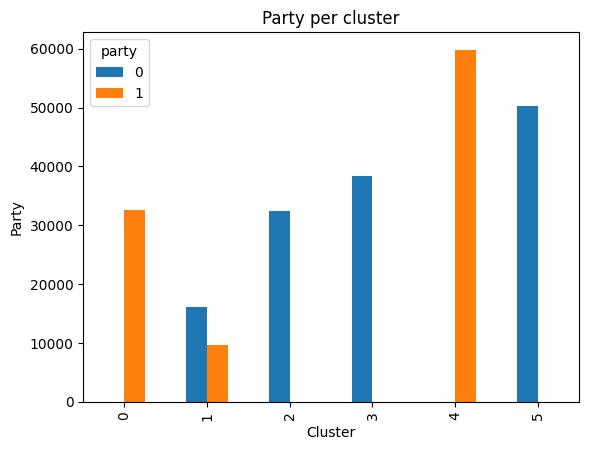

In [43]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')
plt.ylabel('Party')
plt.show()

Construct a distance matrix among cluster centroids.

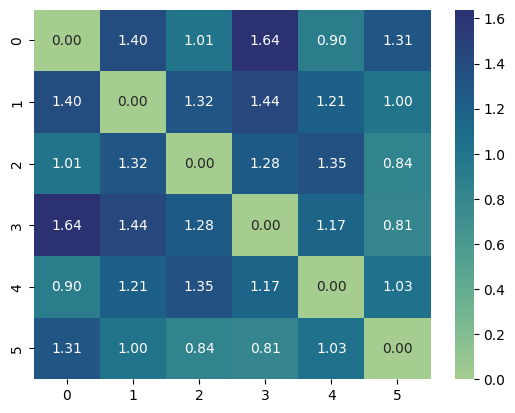

In [45]:
centroid_distance_matrix = squareform(pdist(kmeans.cluster_centers_))
sns.heatmap(centroid_distance_matrix, annot=True, fmt = '.2f', cmap='crest')
plt.show()

Construct matrix displaying correlation of attribute values to belonging to a certain cluster.

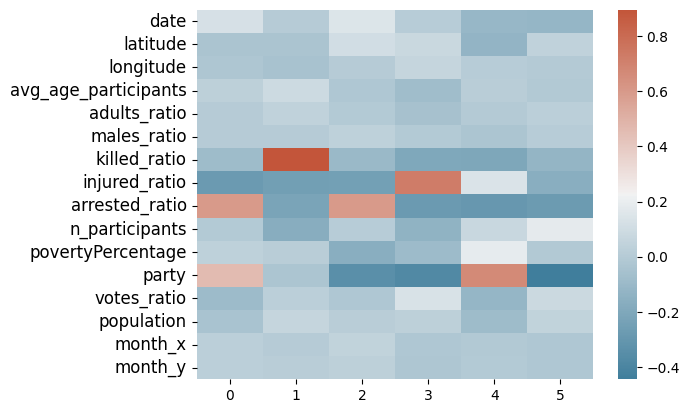

In [46]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(kmeans.labels_), n_clusters))
onehot[np.arange(len(kmeans.labels_)), kmeans.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, numeric_dataset.columns, rotation=0, fontsize=12)
plt.show()

Compute the similarity matrix of a sample of the dataset.

In [38]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = kmeans.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])

([], [])

In [39]:
kmeans.cluster_centers_.shape

(6, 16)

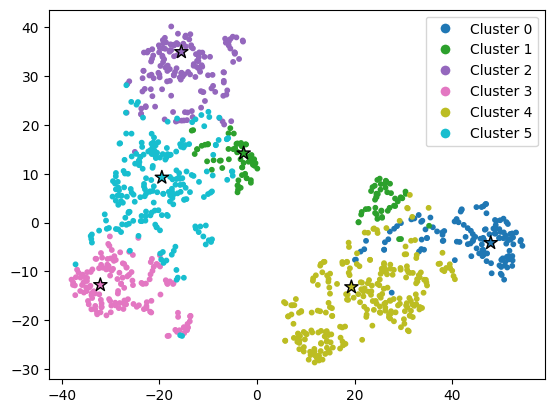

In [75]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = np.concatenate((downsampled_dataset, kmeans.cluster_centers_))
tsne_labels = np.concatenate((downsampled_labels, range(n_clusters)))
tsne_map = tsne.fit_transform(tsne_dataset)

scatter = plt.scatter(tsne_map[:-n_clusters, 0], tsne_map[:-n_clusters, 1], c = tsne_labels[:-n_clusters], s=10, cmap='tab10')
plt.scatter(tsne_map[-n_clusters:, 0], tsne_map[-n_clusters:, 1], c = tsne_labels[-n_clusters:], s=100, cmap='tab10', marker='*', edgecolors='black')

#for i in range(n_clusters):
#    plt.annotate(i, tsne_map[-n_clusters + i, :], fontsize=20)

# Get unique cluster labels
unique_labels = set(tsne_labels[:-n_clusters])

# Create a legend with a color for each cluster
legend_entries = []
for label in unique_labels:
    # Find the indices of data points with the current label
    indices = tsne_labels[:-n_clusters] == label
    # Add a legend entry for the current label with the corresponding color
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8, label=f'Cluster {label}'))

# Add legend to the plot
plt.legend(handles=legend_entries, loc='upper right')
    
plt.show()

## 2.3 Distribution of variables: within clusters vs whole dataset

In [ ]:
print(kmeans.labels_.shape)
print(numeric_dataset.shape)

(239381,)
(239381, 16)


In [ ]:
# Plot distribution of average age for whole dataset and clusters
numeric_dataset_with_clusters = numeric_dataset.copy()
numeric_dataset_with_clusters['cluster'] = kmeans.labels_

sns.displot(numeric_dataset_with_clusters, x="avg_age_participants", kind='kde', hue="cluster")

sns.displot(numeric_dataset_with_clusters, x="males_ratio", kind='kde', hue="cluster")

# Stretch horizontally
plt.gcf().set_size_inches(20, 5)


In [ ]:
sns.displot(numeric_dataset_with_clusters, x="povertyPercentage", y='n_participants', hue="cluster")
plt.ylim(0,15)

(0.0, 15.0)

In [ ]:
sns.displot(numeric_dataset_with_clusters, x="povertyPercentage", y='n_participants', kind='kde', hue="cluster")
# Restric the plot to number of participants between 0 and 30
plt.ylim(0, 8)

In [ ]:
print(numeric_dataset.shape)

In [ ]:
plt.scatter(numeric_dataset['longitude'], numeric_dataset['latitude'],  c=kmeans.labels_, s=20)
plt.scatter(centers_df['longitude'], centers_df['latitude'], marker='*', c='r', s=150)
#plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

# Best Clustering Approach